In [1]:
# import os
import os

# import numpy 
from numpy import expand_dims
import numpy as np
np.random.seed(0) 

# import deep learning package
import tensorflow as tf
tf.compat.v1.set_random_seed(0)
import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Activation
from keras.models import Sequential, load_model

import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

# import visulation package
import matplotlib.pyplot as plt
%matplotlib inline

# import pandas
import pandas as pd

# import usefull package
from tqdm import tqdm
import itertools

# Introduction

This notebook implements the latest version of our work on the CNN part. This notebook should run until the end without errors. So, don't hesitate to come back to us if you have any problem.

You can find the dataset with the following links because there are too big to attach it with the project. So, our first idea was to use the dataset: https://www.kaggle.com/datasets/grassknoted/asl-alphabet?resource=download to train and test it. As we then wanted to use our model to make predictions from a camera. We chose to see the predictions on a completely different dataset: https://www.kaggle.com/datasets/danrasband/asl-alphabet-test. As expected the results were much worse but still much better than the random one. So, to improve our performance and the robustness of our model we chose to increase the second dataset which is 100 times smaller to add it in the training set. This is the version implemented in this notebook.

# Data importation

You need to move your current directory into the folder with the files with dataset and model weight sand then everything can work regardless of your operating system (linux, mac, windows).

$\textbf{/!\ You need to download the model with this link :}$

https://drive.google.com/drive/folders/1jZwygJjX02akEte82-3JEjjlpmglEJGR?usp=sharing

Then put it in your current directory

* my_model_20_new.h5
* my_model_60_new.h5
* my_model_without_aug.h5

In [2]:
# os.chdir("put your work space directory")

In [3]:
# get current work directory

path_work_space = os.getcwd()

# the first path is going to 'asl_alphabet_train' in the dataset from 
#https://www.kaggle.com/datasets/grassknoted/asl-alphabet?resource=download
# we are not using the testing set because it is too little
train_dir = os.path.join(path_work_space,"asl_alphabet_train")

# the second path is going to the dataset from https://www.kaggle.com/datasets/danrasband/asl-alphabet-test
eval_dir = os.path.join(path_work_space,"asl_alphabet_real_world")

# the third was a curisity. There are not del, space, nothing just alphabets and also figures (0,...,9) and data are really differents ...
# https://www.massey.ac.nz/~albarcza/gesture_dataset2012.html

# the folder must contain the 5 datasets 
    # handgesturedataset_part1
    # handgesturedataset_part2
    # handgesturedataset_part3
    # handgesturedataset_part4
    # handgesturedataset_part5
test_dir = os.path.join(path_work_space, "asl_handgesturedataset")

This function is used to load the data from the given path

In [4]:
def read_datasets(directory, all_labels):
    list_images = []
    list_labels = []
    for n_class, label in tqdm(enumerate(all_labels)):
        for file in os.listdir(os.path.join(directory, label)):
            path_im = os.path.join(directory, label, file)
            
            # we read the image
            image = cv2.imread(path_im,)
            image = cv2.resize(image, (64, 64))
            
            # we can add to the list
            list_images.append(image)
            list_labels.append(n_class)
            
    list_images = np.array(list_images,)
    list_labels = np.array(list_labels)
    return list_images, list_labels 

It is used to load the third dataset which have a different format

In [5]:
#Helper function to load images from given directories
def read_datasets_2(directory, all_labels):
    list_images = []
    list_labels = []
    for path in os.listdir(directory):
        for file in os.listdir(os.path.join(directory, path)):
            n_class = file.split("_")[1].upper()
            if n_class in all_labels:
                path_im = os.path.join(directory, path, file)
                
                # we read the image
                image = cv2.imread(path_im,)
                image = cv2.resize(image, (64, 64))
                
                # we can add to the list
                list_images.append(image)
                list_labels.append(n_class)
                
    list_images = np.array(list_images,)
    list_labels = np.array(list_labels)
    return list_images, list_labels

The following cell is used to load the data and compute the label names

In [6]:
all_labels = sorted(os.listdir(train_dir))
images, labels = read_datasets(train_dir, all_labels)
X_eval, y_eval = read_datasets(eval_dir, all_labels)

29it [01:58,  4.08s/it]
29it [00:01, 23.70it/s]


# Data processing

## Data split

The first dataset is then split in 0.9 in training set and 0.1 in testing

In [8]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(images, labels, test_size = 0.1, stratify = labels)

In [9]:
print(f"we have {len(X_train_1)} instances in the training set")
print(f"we have {len(X_test_1)} instances in the testing set")

we have 78300 instances in the training set
we have 8700 instances in the testing set


The we split the second data set with 0.7 in the training set and 0.3 in the test set.

We have chosen 0.3 to have more data for testing. The training set will be increase by data generation

In [10]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_eval, y_eval, test_size = 0.3, stratify = y_eval)

In [11]:
print(len(X_train_2))
print(len(X_test_2))

609
261


We can see that we have a ratio of about 100 between the two datasets. On the other hand, we were not afraid to augment this game because the first game is a video that has been cut into images. So it looks somewhat like data augmentation (the hand moves, moves back, moves forward, moves backwards...)

## Data Augmentation

The parameter that allows you to choose the number of images is n.
If n = 60 then we will have n-1 = 59 new images in addition to the original image.

Furthermore, we have only increased the training set and left the test set untouched. It is important not to change the test set

In [12]:
list_X_train_2 = []
list_y_train_2 = []

n = 60 # number of image generated from 1 (the original is counted in n_new = n - 1)

for img, label in zip(X_train_2, y_train_2):
    list_X_train_2.append(img)
    list_y_train_2.append(label)
    img = expand_dims(img, 0)

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        horizontal_flip=True,
        width_shift_range=0.2, 
        height_shift_range=0.2,
        brightness_range=[0.4,1.5],
        fill_mode='nearest')

    aug_iter = datagen.flow(img, batch_size=1)

    
    # generate batch of images
    for i in range(n-1):
        image = next(aug_iter)[0].astype('uint8')
        list_X_train_2.append(image)
        list_y_train_2.append(label)
   

# Merge dataset

Then we merged the data from the first dataset and the second with the increase

In [13]:
X_train = np.concatenate((X_train_1, np.array(list_X_train_2)))
X_test = np.concatenate((X_test_1, X_test_2))

y_train = np.concatenate((y_train_1, np.array(list_y_train_2)))
y_test = np.concatenate((y_test_1, y_test_2))

In [14]:
len(X_train)

114840

In [15]:
len(X_test)

8961

To make sure that the data is well mixed and that we don't have only A, then only B and so on... it could appear with data augmentation

In [16]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

# Data visualisation

In [17]:
def print_images(im, all_labels):
    # we have a new class each n 
    # so we display one image each n to have each classes
    n = int(len(im) / len(all_labels))+1
    cols = 6
    rows = 7
    fig = plt.figure(figsize = (18, 21))

    for i in range(len(all_labels)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(im[int(n*i)])
        plt.title(all_labels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

We can see that we have data from both datasets and that data is augmented

Training Images: 


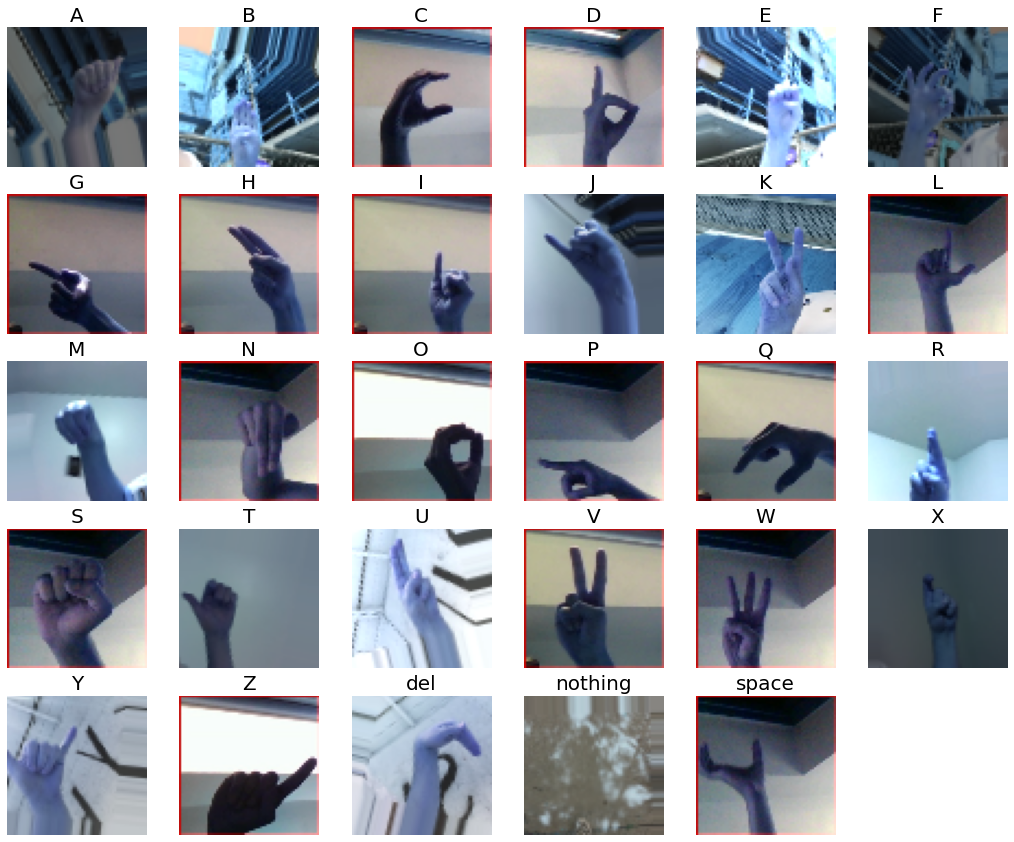

In [18]:
y_train_in = y_train.argsort()

print("Training Images: ")
print_images(X_train[y_train_in], all_labels)

However, for the test set the data for the second set is much lower. We can see this below. On the other hand, there is no augmented data

Testing images: 


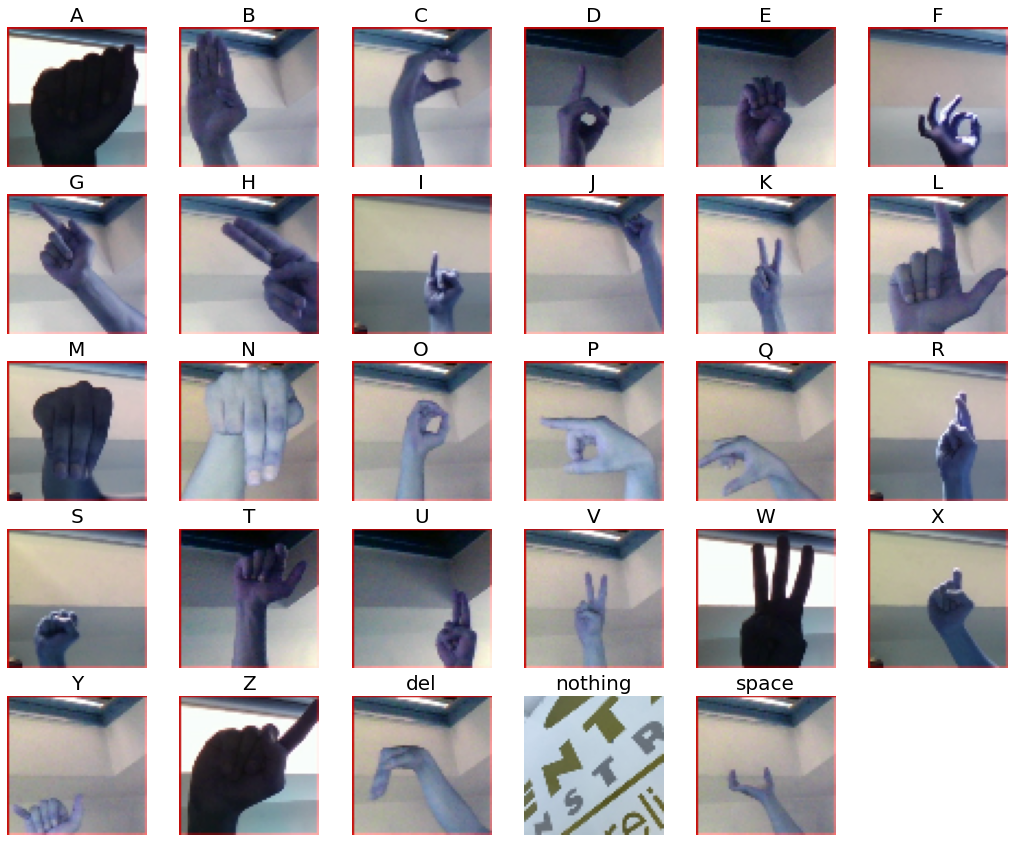

In [19]:
y_test_in = y_test.argsort()

print("Testing images: ")
print_images(X_test[y_test_in], all_labels)

# Training

Then, for classification models we prefer to have a one hot encoding representation as labels

In [20]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_test_2 = keras.utils.to_categorical(y_test_2)

There is also a need to standardise the data so that the CNNs can converge

In [21]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

The model is defined as

In [22]:
model = Sequential()

# first layer of convolution
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', input_shape = (64, 64, 3)))
model.add(Activation('relu'))

# second layer of convolution
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))

# third layer of convolution
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same'))
model.add(Activation('relu'))

# forth layer of convolution
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))

# fifth layer of convolution
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# fully connected
model.add(Flatten())

# prediction
model.add(Dense(29, activation='softmax'))

This is what the model consists of

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                        

Then, we compile by specifying the characteristics for the optimisation 

In [24]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

* if with_run = True : it will fit the CNN

* otherwise with_run = False : it will load the file with the CNN weights

In [25]:
with_run = False
if with_run:
    hist = model.fit(X_train, y_train, epochs = 7, batch_size = 64)
    model.save('my_model_60_new.h5')
    pd.DataFrame(hist.history).plot()
else:
    model = load_model('my_model_without_aug.h5')
    model20 = load_model('my_model_20_new.h5')
    model60 = load_model('my_model_60_new.h5')

# Evaluation

This first function is useful for displaying the confusion matrix

In [26]:
def plot_confusion_matrix(y, y_pred, all_labels):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(all_labels))
    plt.xticks(tick_marks, all_labels, rotation=45)
    plt.yticks(tick_marks, all_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

this second function is useful for displaying the confusion matrix for the third dataset because it don't have nothing, del and space as input

In [27]:
def plot_confusion_matrix_2(y, y_pred, all_labels_world):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(all_labels_world))
    plt.xticks(tick_marks, all_labels_world, rotation=45)
    plt.yticks(tick_marks, all_labels_world)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

## quick view

first model without data augmentation

In [28]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print(f'Accuracy for test images:{score[1]}')

Accuracy for test images:0.9790201783180237


second model with data augmentation with factor of 20

In [29]:
score = model20.evaluate(x = X_test, y = y_test, verbose = 0)
print(f'Accuracy for test images:{score[1]}')

Accuracy for test images:0.9896216988563538


third model with data augmentation with factor of 60

In [30]:
score = model60.evaluate(x = X_test, y = y_test, verbose = 0)
print(f'Accuracy for test images:{score[1]}')

Accuracy for test images:0.9957594275474548


## Results

### first model without data augmentation on the validation set.

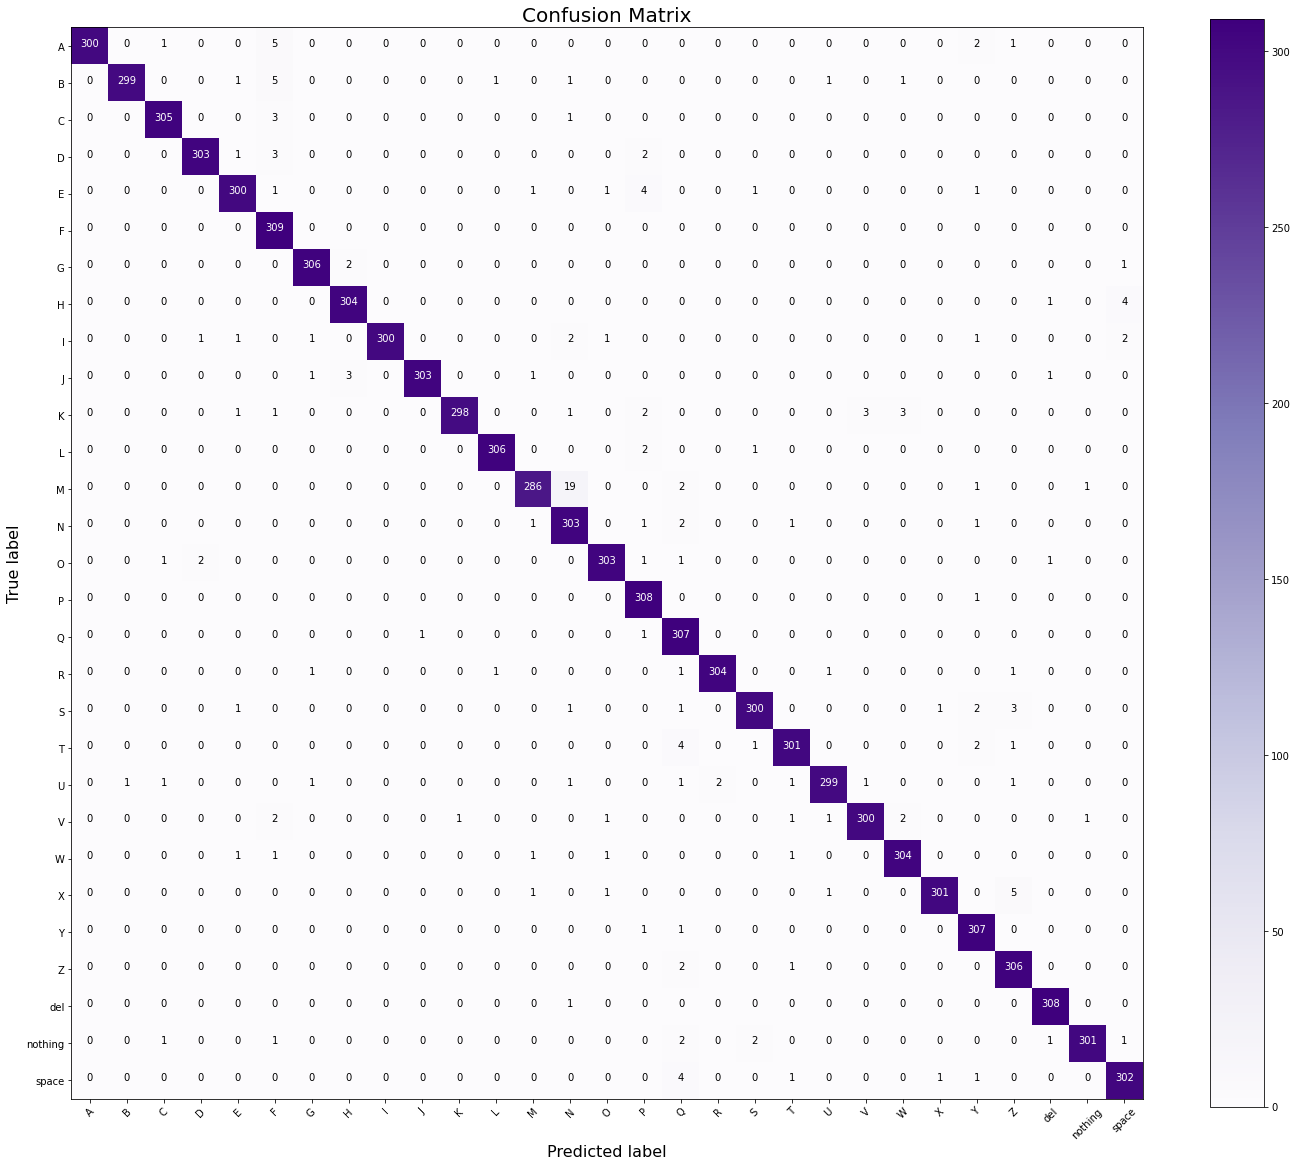

In [31]:
y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred, all_labels)

In [32]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       309
           1       1.00      0.97      0.98       309
           2       0.99      0.99      0.99       309
           3       0.99      0.98      0.99       309
           4       0.98      0.97      0.98       309
           5       0.93      1.00      0.97       309
           6       0.99      0.99      0.99       309
           7       0.98      0.98      0.98       309
           8       1.00      0.97      0.99       309
           9       1.00      0.98      0.99       309
          10       1.00      0.96      0.98       309
          11       0.99      0.99      0.99       309
          12       0.98      0.93      0.95       309
          13       0.92      0.98      0.95       309
          14       0.98      0.98      0.98       309
          15       0.96      1.00      0.98       309
          16       0.94      0.99      0.96       309
          17       0.99    

### first model without data augmentation on the test set.

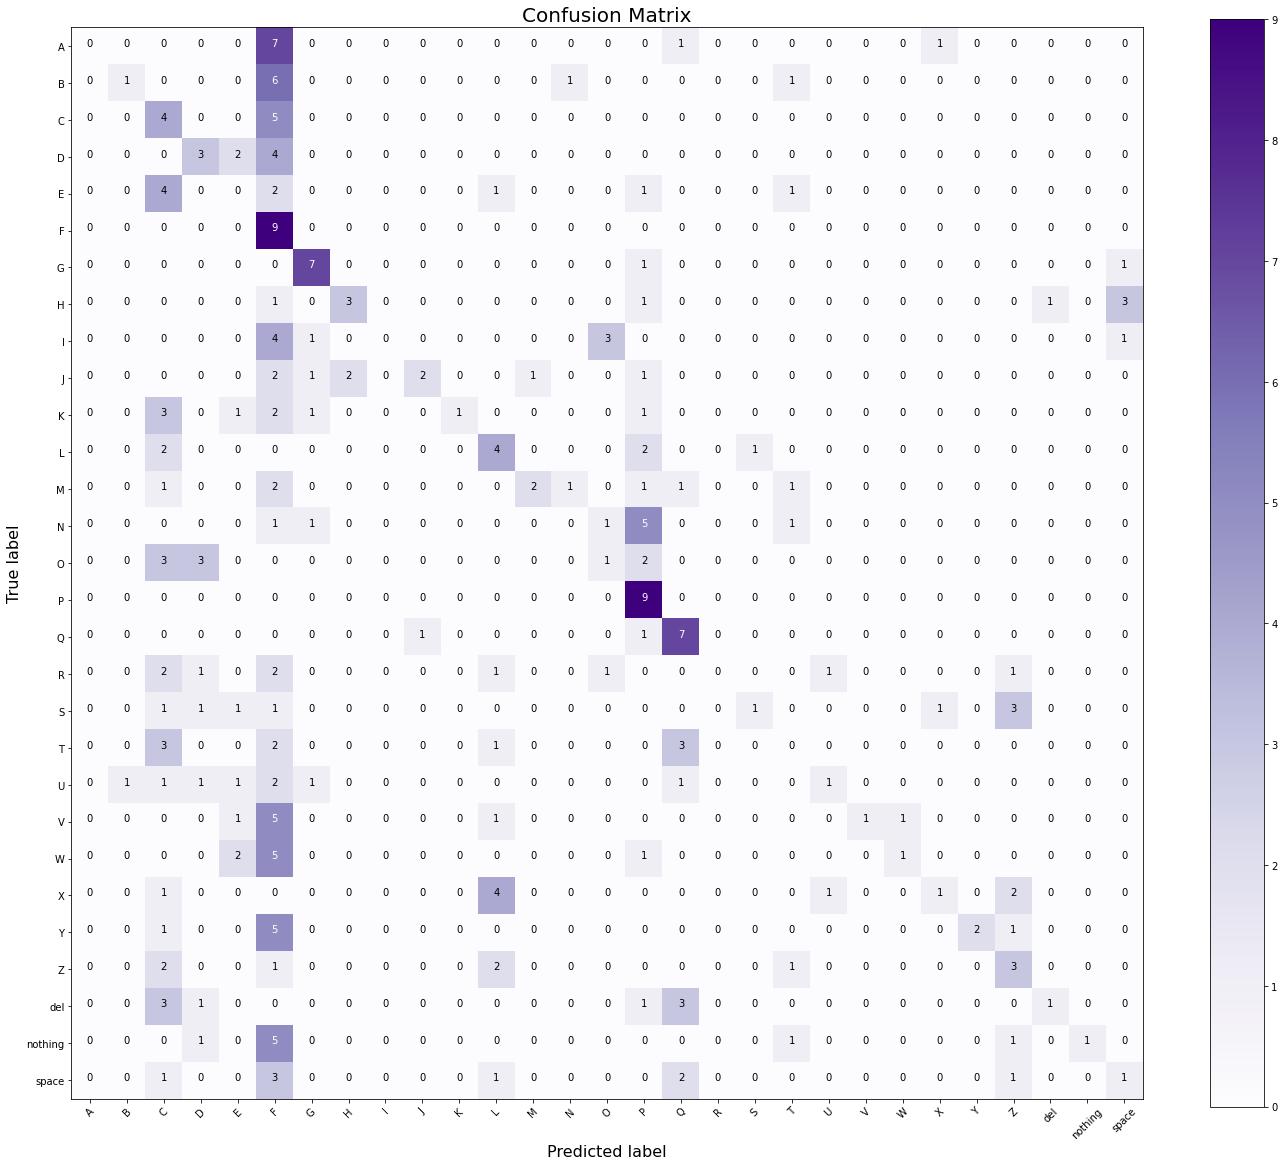

In [33]:
y_test_pred = model.predict(X_test_2, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test_2, y_test_pred, all_labels)

In [34]:
print(classification_report(np.argmax(y_test_2, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.50      0.11      0.18         9
           2       0.12      0.44      0.20         9
           3       0.27      0.33      0.30         9
           4       0.00      0.00      0.00         9
           5       0.12      1.00      0.21         9
           6       0.58      0.78      0.67         9
           7       0.60      0.33      0.43         9
           8       0.00      0.00      0.00         9
           9       0.67      0.22      0.33         9
          10       1.00      0.11      0.20         9
          11       0.27      0.44      0.33         9
          12       0.67      0.22      0.33         9
          13       0.00      0.00      0.00         9
          14       0.17      0.11      0.13         9
          15       0.33      1.00      0.50         9
          16       0.39      0.78      0.52         9
          17       0.00    

C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### second model with data augmentation factor 20 on the validation set.

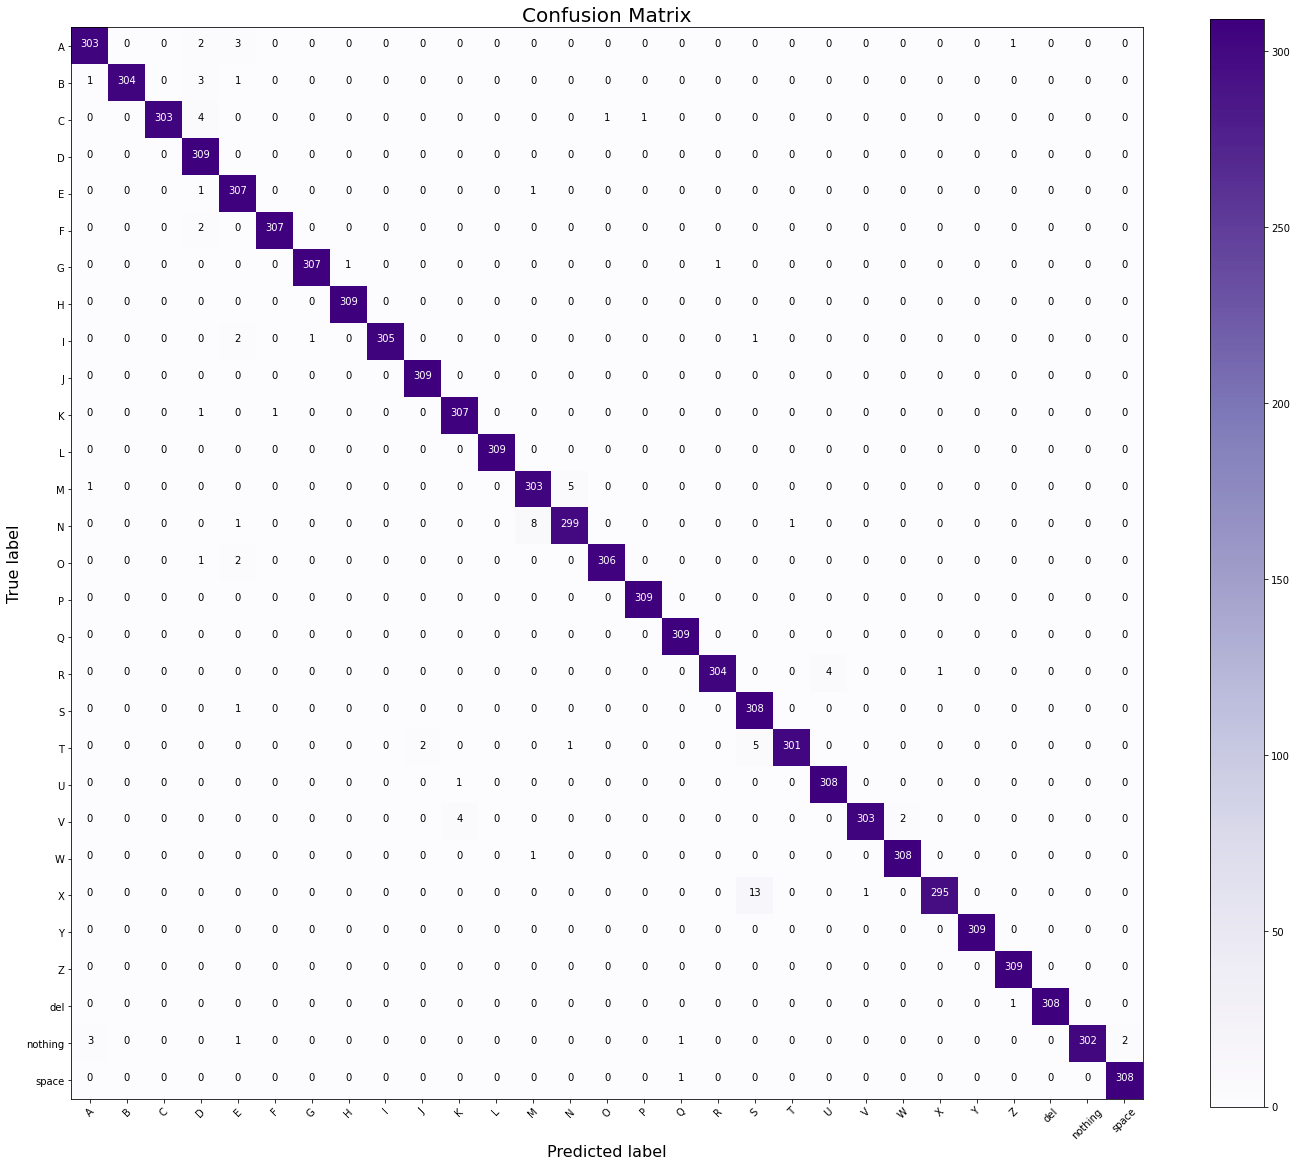

In [35]:
y_test_pred = model20.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred, all_labels)

In [36]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       309
           1       1.00      0.98      0.99       309
           2       1.00      0.98      0.99       309
           3       0.96      1.00      0.98       309
           4       0.97      0.99      0.98       309
           5       1.00      0.99      1.00       309
           6       1.00      0.99      1.00       309
           7       1.00      1.00      1.00       309
           8       1.00      0.99      0.99       309
           9       0.99      1.00      1.00       309
          10       0.98      0.99      0.99       309
          11       1.00      1.00      1.00       309
          12       0.97      0.98      0.97       309
          13       0.98      0.97      0.97       309
          14       1.00      0.99      0.99       309
          15       1.00      1.00      1.00       309
          16       0.99      1.00      1.00       309
          17       1.00    

### second model with data augmentation factor 20 on the test set.

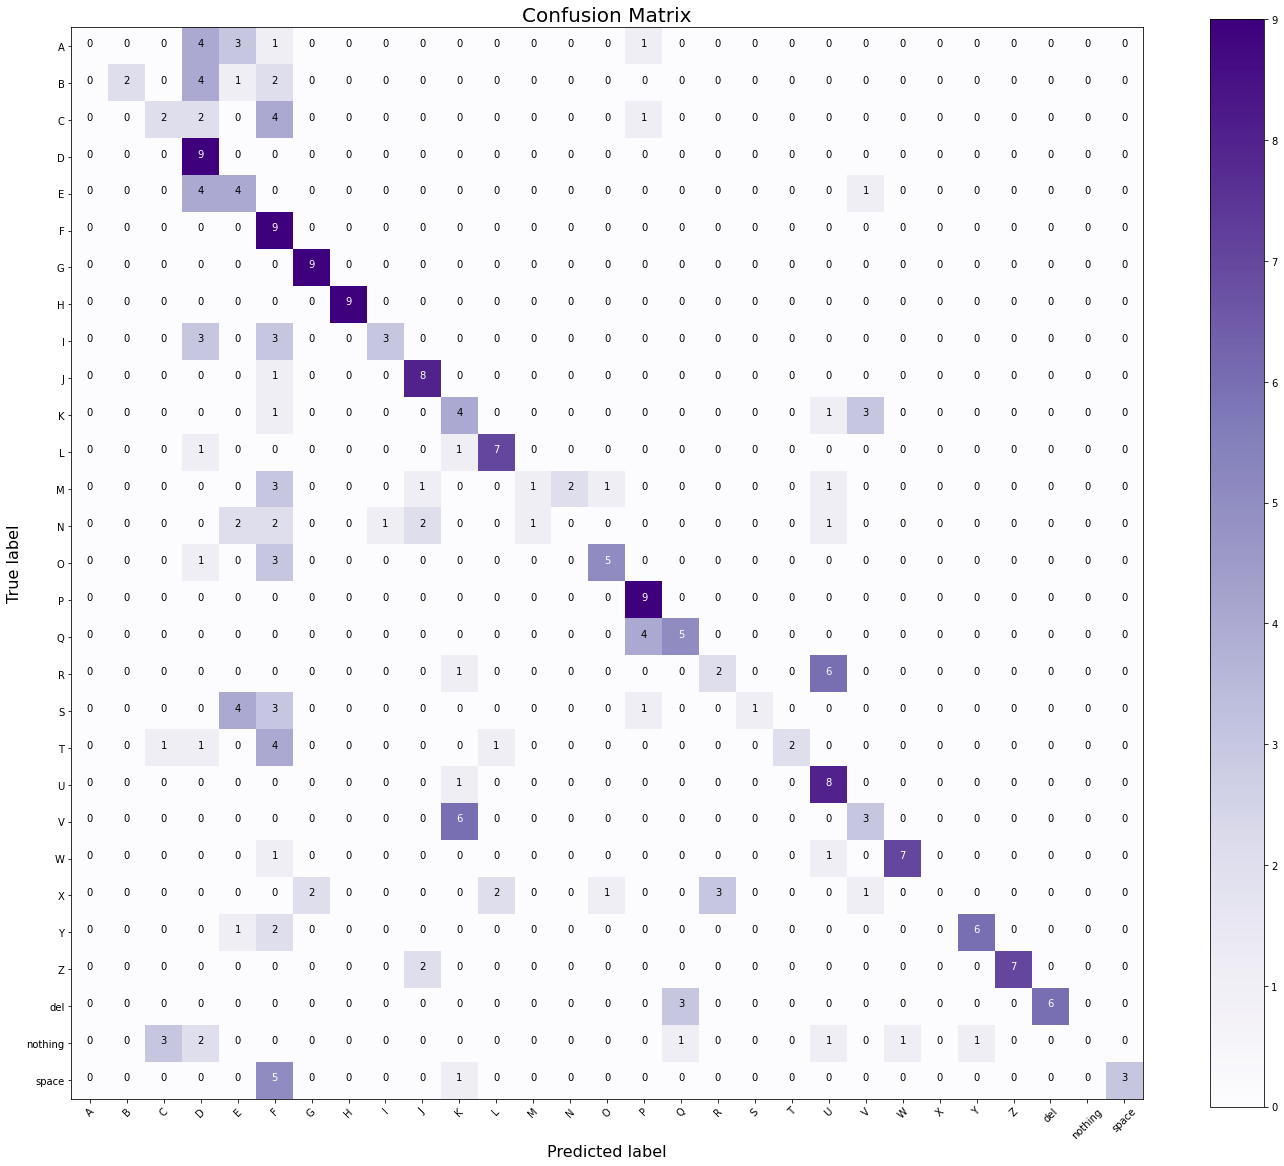

In [37]:
y_test_pred = model20.predict(X_test_2, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test_2, y_test_pred, all_labels)

In [38]:
print(classification_report(np.argmax(y_test_2, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       1.00      0.22      0.36         9
           2       0.33      0.22      0.27         9
           3       0.29      1.00      0.45         9
           4       0.27      0.44      0.33         9
           5       0.20      1.00      0.34         9
           6       0.82      1.00      0.90         9
           7       1.00      1.00      1.00         9
           8       0.75      0.33      0.46         9
           9       0.62      0.89      0.73         9
          10       0.29      0.44      0.35         9
          11       0.70      0.78      0.74         9
          12       0.50      0.11      0.18         9
          13       0.00      0.00      0.00         9
          14       0.71      0.56      0.63         9
          15       0.56      1.00      0.72         9
          16       0.56      0.56      0.56         9
          17       0.40    

C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

### third model with data augmentation factor 60 on the validation set.

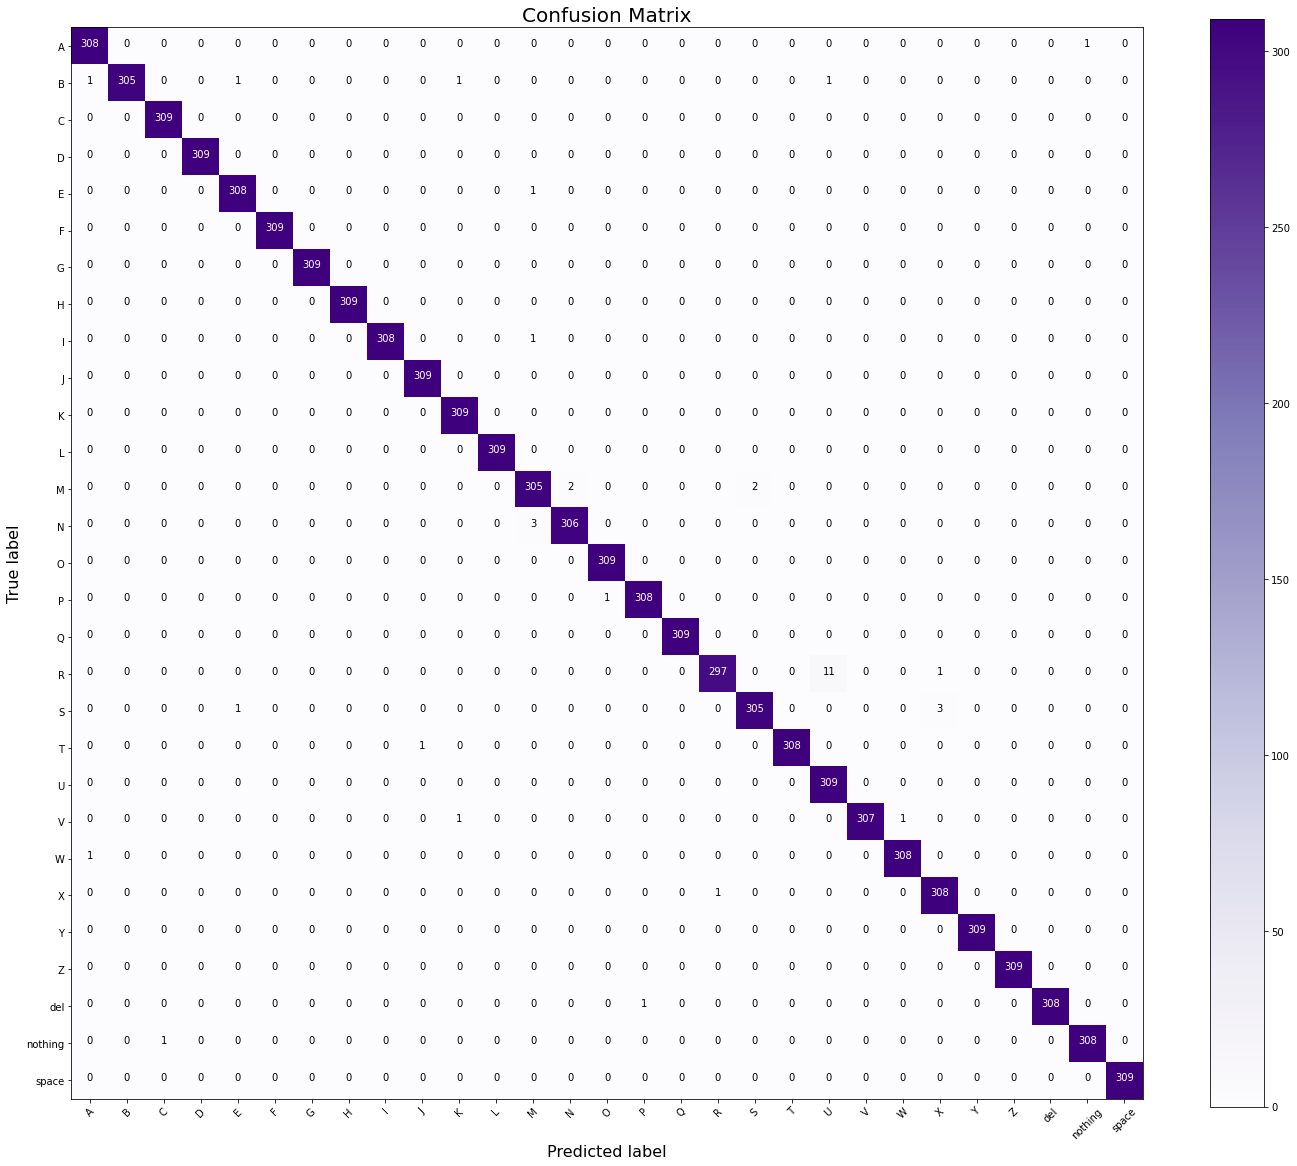

In [39]:
y_test_pred = model60.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred, all_labels)

In [40]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       309
           1       1.00      0.99      0.99       309
           2       1.00      1.00      1.00       309
           3       1.00      1.00      1.00       309
           4       0.99      1.00      1.00       309
           5       1.00      1.00      1.00       309
           6       1.00      1.00      1.00       309
           7       1.00      1.00      1.00       309
           8       1.00      1.00      1.00       309
           9       1.00      1.00      1.00       309
          10       0.99      1.00      1.00       309
          11       1.00      1.00      1.00       309
          12       0.98      0.99      0.99       309
          13       0.99      0.99      0.99       309
          14       1.00      1.00      1.00       309
          15       1.00      1.00      1.00       309
          16       1.00      1.00      1.00       309
          17       1.00    

### third model with data augmentation factor 60 on the test set.

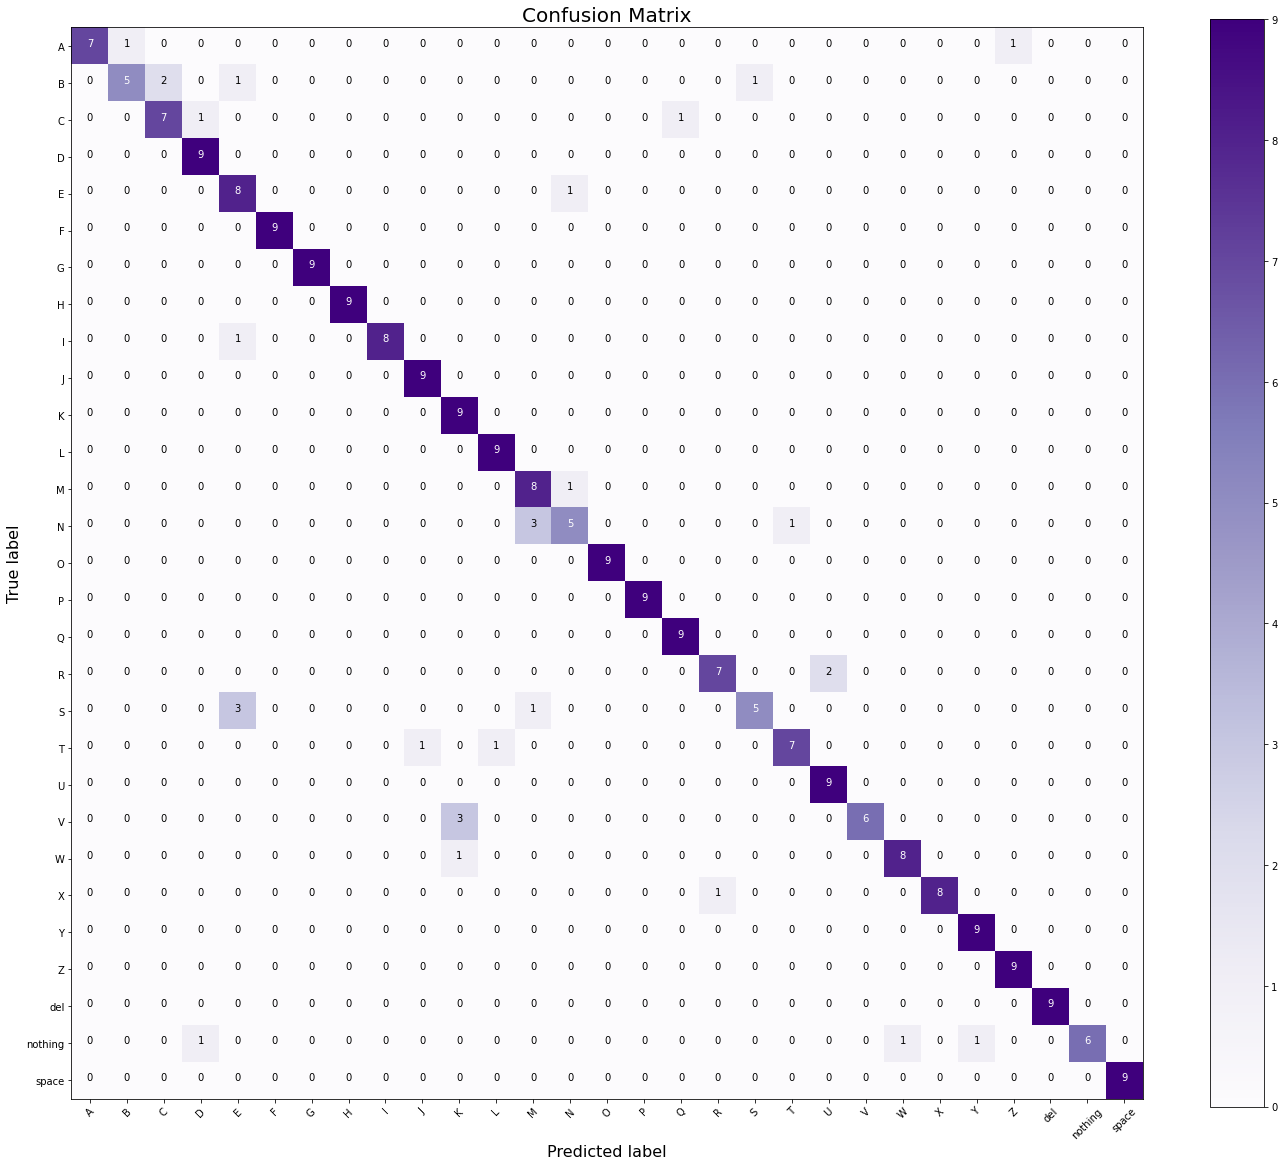

In [41]:
y_test_pred = model60.predict(X_test_2, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test_2, y_test_pred, all_labels)

In [42]:
print(classification_report(np.argmax(y_test_2, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       0.83      0.56      0.67         9
           2       0.78      0.78      0.78         9
           3       0.82      1.00      0.90         9
           4       0.62      0.89      0.73         9
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         9
           8       1.00      0.89      0.94         9
           9       0.90      1.00      0.95         9
          10       0.69      1.00      0.82         9
          11       0.90      1.00      0.95         9
          12       0.67      0.89      0.76         9
          13       0.71      0.56      0.63         9
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         9
          16       0.90      1.00      0.95         9
          17       0.88    

# Additional test

this part is not in the repport and it is additional work and coriosities

With this 3rd dataset we haven't images for space, del and nothing. One way is to do oversampling wih previous and integrated this data in the first for training. Otherwise, it could be intresting to do transfert learning

Here, we just tryto see but the result are not good even if we use our best model

In [44]:
X_world, y_world = read_datasets_2(test_dir, all_labels)

In [45]:
all_labels_world = all_labels[:-3]
map_label_figure = {all_labels_world[i]:i for i in range(len(all_labels_world))}
y_world = [map_label_figure[y_world[i]] for i in range(len(y_world))]
y_world = keras.utils.to_categorical(y_world)

In [46]:
X_world = X_world.astype('float32')/255.0

In [47]:
y_test_pred = model60.predict(X_world, batch_size = 64, verbose = 0)

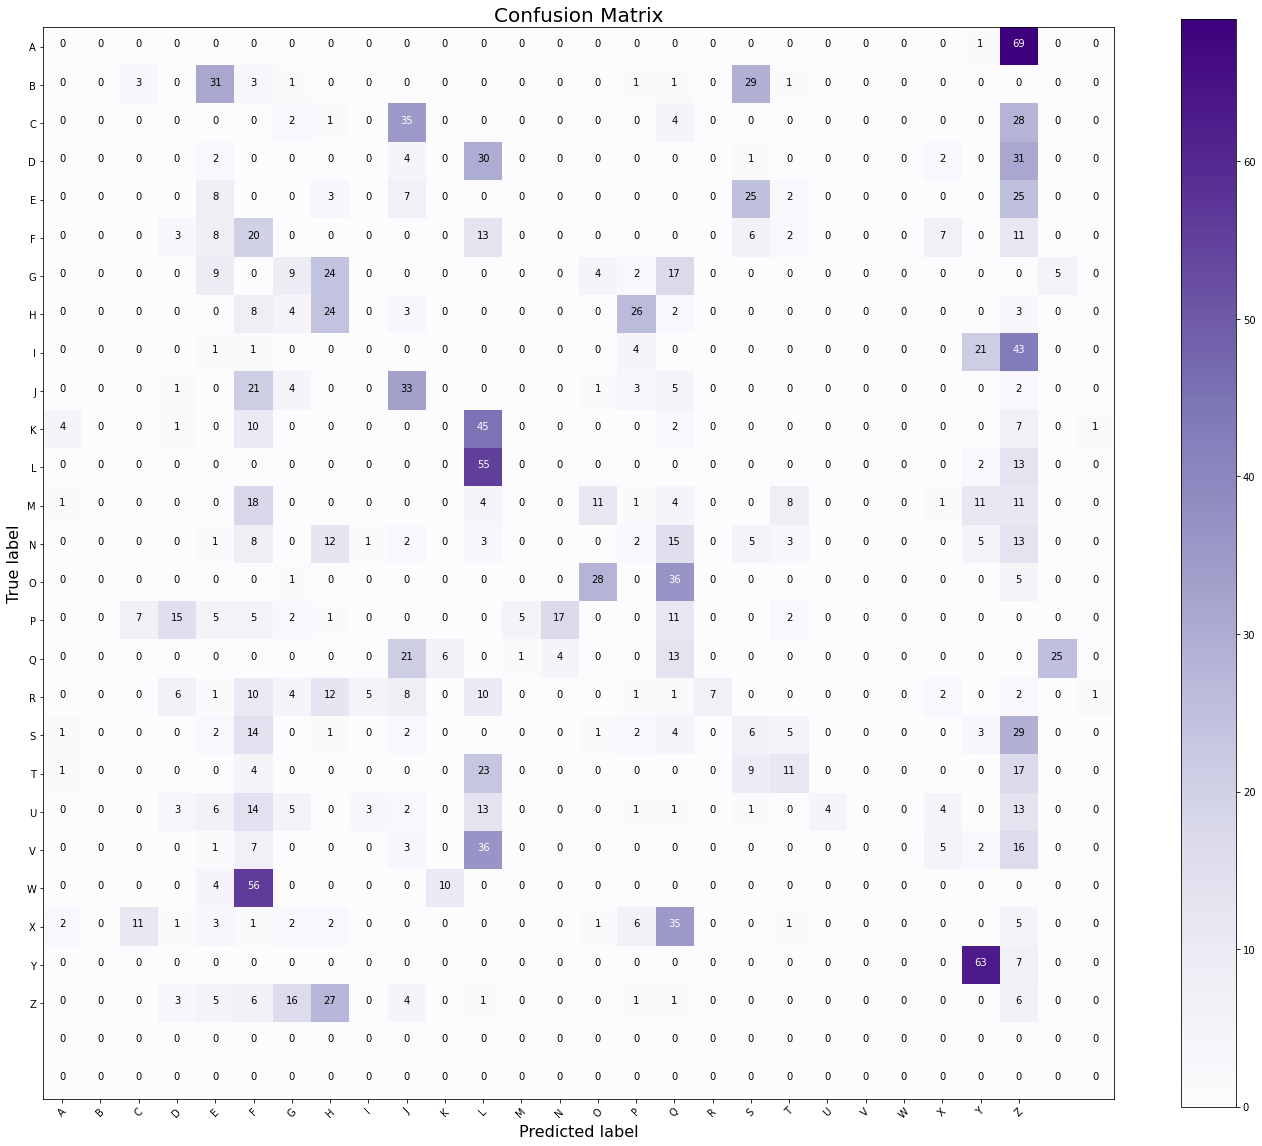

In [48]:
plot_confusion_matrix_2(y_world, y_test_pred, all_labels_world)

In [49]:
print(classification_report(np.argmax(y_world, axis=1), np.argmax(y_test_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00        70
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        70
           4       0.09      0.11      0.10        70
           5       0.10      0.29      0.14        70
           6       0.18      0.13      0.15        70
           7       0.22      0.34      0.27        70
           8       0.00      0.00      0.00        70
           9       0.27      0.47      0.34        70
          10       0.00      0.00      0.00        70
          11       0.24      0.79      0.36        70
          12       0.00      0.00      0.00        70
          13       0.00      0.00      0.00        70
          14       0.61      0.40      0.48        70
          15       0.00      0.00      0.00        70
          16       0.09      0.19      0.12        70
          17       1.00    

C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\baptc\anaconda3\envs\sign_recognition_project\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie